# Import library

In [5]:
import os
import os, sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
pd.set_option("display.max_column", 100)

In [7]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

# Data load

In [8]:
df_all = pd.read_csv("data/df_data_v3_1/df_all_v3_12_added_owid.csv")

In [9]:
size_and_ratio(df_all, 'pcr_result')

Sum : 15376 (2,)


,size,ratio
pcr_result,,
1,10277,0.668379
0,5099,0.331621


In [13]:
df_all[df_all['patient_id'] == 30888]

,patient_id,selfcheck_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask
422,30888,2022-03-04,1,0,1,0,1,1,1,1,0,0,1,1,1,0,0,0.394016,0.223707,0.037306,1,1.0,0.55,0,0,TRAIN,KOR,2022-03-04,0.105452,0.0,0.022502,0.0,0.095740,0.0,0.025695,0.0,0.005947,0.0,0.014781,0.0,0.085131,0.0,0.000000,1.0,0.0,1.0,0.330999,0.0,0.040748,0.0,0.031652,0.0,0.096766,0.0,0.568216,0.0,0.666847,0.0,0.671211,0.0,0.408321,0.0,0.014362,0.0,0.000427,0.0,0.88913,0.0,0.0,1.0
1121,30888,2022-03-10,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.458205,0.455445,0.060971,1,1.0,0.55,3,0,TRAIN,KOR,2022-03-10,0.147579,0.0,0.027619,0.0,0.136820,0.0,0.028887,0.0,0.006587,0.0,0.023224,0.0,0.118888,0.0,0.000000,1.0,0.0,1.0,0.353140,0.0,0.043451,0.0,0.023376,0.0,0.102390,0.0,0.569791,0.0,0.667235,0.0,0.671527,0.0,0.411909,0.0,0.010784,0.0,0.000598,0.0,0.88913,0.0,0.0,1.0
5378,30888,2022-04-06,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.298772,0.361749,0.144482,1,1.0,0.55,2,0,TRAIN,KOR,2022-04-06,0.387715,0.0,0.024136,0.0,0.131677,0.0,0.054004,0.0,0.011861,0.0,0.040399,0.0,0.120487,0.0,0.000000,1.0,0.0,1.0,0.298526,0.0,0.052470,0.0,0.013290,0.0,0.050060,0.0,0.575597,0.0,0.668320,0.0,0.672709,0.0,0.425600,0.0,0.005098,0.0,0.000683,0.0,0.88913,0.0,0.0,1.0
7623,30888,2022-08-04,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.356130,0.181642,0.000000,1,1.0,0.55,3,0,TRAIN,KOR,2022-08-04,0.537075,0.0,0.009094,0.0,0.046262,0.0,0.075299,0.0,0.001087,0.0,0.003471,0.0,0.033115,0.0,0.034848,0.0,0.0,1.0,0.067736,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.606451,0.0,0.669637,0.0,0.674679,0.0,0.506147,0.0,0.012637,0.0,0.000085,0.0,0.88913,0.0,0.0,1.0
7838,30888,2022-08-20,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0.140678,0.178563,0.000000,1,1.0,0.55,5,0,TRAIN,KOR,2022-08-20,0.589538,0.0,0.010907,0.0,0.066111,0.0,0.077803,0.0,0.002685,0.0,0.007676,0.0,0.054584,0.0,0.046881,0.0,0.0,1.0,0.105158,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.611102,0.0,0.669792,0.0,0.674758,0.0,0.518575,0.0,0.007258,0.0,0.000085,0.0,0.88913,0.0,0.0,1.0
8897,30888,2022-12-29,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.164398,0.104950,0.268277,1,1.0,0.55,3,0,TRAIN,KOR,2022-12-29,0.770735,0.0,0.006022,0.0,0.034392,0.0,0.095912,0.0,0.002430,0.0,0.007717,0.0,0.063019,0.0,0.000000,1.0,0.0,1.0,0.037394,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.670179,0.0,0.675309

In [23]:

df_negative = df_all[df_all['pcr_result'] == 0]
sample = df_negative['patient_id'].sample(15)
for p_id in sample:
    print(p_id, df_negative[df_negative['patient_id'] == p_id].shape)

30177 (9, 70)
64910 (19, 70)
21235 (1, 70)
64716 (4, 70)
33374 (1, 70)
36168 (3, 70)
32360 (4, 70)
21298 (2, 70)
20429 (1, 70)
63014 (1, 70)
57052 (1, 70)
26658 (1, 70)
52492 (1, 70)
60811 (18, 70)
29175 (27, 70)


In [10]:
df_all[df_all['pcr_result'] == 0].sample(10)

,patient_id,selfcheck_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask
4479,35684,2022-03-30,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.391272,0.516121,0.134373,1,1.0,0.27,2,0,TRAIN,KOR,2022-03-30,0.340329,0.0,0.035801,0.0,0.173797,0.0,0.047481,0.0,0.013811,0.0,0.044940,0.0,0.138968,0.0,0.000000,1.0,0.000000,1.0,0.340129,0.0,0.050899,0.0,0.017584,0.0,0.065249,0.0,0.574564,0.0,0.667932,0.0,0.672472,0.0,0.423407,0.0,0.006976,0.0,0.000256,0.0,0.88913,0.0,0.000000,1.0
7845,64909,2022-08-20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.140678,0.178563,0.000000,1,0.0,0.63,5,0,TRAIN,KOR,2022-08-20,0.589538,0.0,0.010907,0.0,0.066111,0.0,0.077803,0.0,0.002685,0.0,0.007676,0.0,0.054584,0.0,0.046881,0.0,0.000000,1.0,0.105158,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.611102,0.0,0.669792,0.0,0.674758,0.0,0.518575,0.0,0.007258,0.0,0.000085,0.0,0.88913,0.0,0.000000,1.0
14328,30929,2022-04-12,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.263275,0.238875,0.000000,1,1.0,0.38,2,0,TEST,KOR,2022-04-12,0.416530,0.0,0.017767,0.0,0.101264,0.0,0.059445,0.0,0.005467,0.0,0.040581,0.0,0.107353,0.0,0.000000,1.0,0.074114,0.0,0.263974,0.0,0.053515,0.0,0.015318,0.0,0.040121,0.0,0.576237,0.0,0.668552,0.0,0.672866,0.0,0.426995,0.0,0.003766,0.0,0.000427,0.0,0.88913,0.0,0.000000,1.0
8360,53064,2022-10-24,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.145811,0.039769,0.000000,1,1.0,0.32,3,0,TRAIN,KOR,2022-10-24,0.674313,0.0,0.001202,0.0,0.013336,0.0,0.086847,0.0,0.000320,0.0,0.002765,0.0,0.024143,0.0,0.017632,0.0,0.000000,1.0,0.023043,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.614792,0.0,0.669947,0.0,0.675073,0.0,0.528079,0.0,0.000939,0.0,0.000000,0.0,0.88913,0.0,0.000000,1.0
14271,24398,2022-04-10,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.137540,0.146347,0.145407,1,1.0,0.44,6,0,TEST,KOR,2022-04-10,0.408496,0.0,0.013869,0.0,0.108044,0.0,0.058160,0.0,0.010518,0.0,0.040547,0.0,0.118993,0.0,0.000000,1.0,0.000000,1.0,0.268976,0.0,0.053163,0.0,0.006856,0.0,0.043454,0.0,0.576065,0.0,0.668552,0.0,0.672866,0.0,0.426597,0.0,0.004167,0.0,0.000512,0.0,0.88913,0.0,0.063176,0.0
8142,61827,2022-09-15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.149708,0.083423,0.000000,1,0.0,0.23,3,0,TRAIN,KOR,2022-09-15,0.646416,0.0,0.006023,0.0,0.029604,0.0,0.082849,0.0,0.002303,0.0,0.006526,0.0,0.052448,0.0,0.030019,0.0,0.000000,1.0,0.040265,0.0,0.000000,1.0,0.00

# Preprocess

### Null check

In [79]:
print("Null:", df_all.isnull().sum())
df_all = df_all.fillna(0)
print("after fillint total Null:", df_all.isnull().sum().sum())

Null: baby_id                                            0
self_check_date                                    0
cough                                              0
fever                                              0
sore_throat                                        0
                                                  ..
new_people_vaccinated_smoothed_per_hundred_mask    4
hospital_beds_per_thousand_norm                    4
hospital_beds_per_thousand_mask                    4
excess_mortality_cumulative_per_million_norm       4
excess_mortality_cumulative_per_million_mask       4
Length: 70, dtype: int64
after fillint total Null: 0


## Split

In [80]:

df_train = df_all[df_all['split'] == 'TRAIN']
df_val = df_all[df_all['split'] == 'VALIDATE']
df_test = df_all[df_all['split'] == 'TEST']
print(df_train.shape, df_val.shape, df_test.shape)
df_train.head()

(13961, 70) (4750, 70) (4615, 70)


,baby_id,self_check_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask
0,21165,2021-12-08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.178983,0.008614,0.013530,1,1.0,0.39,4,0,TRAIN,KOR,2021-12-08,0.014128,0.0,0.000605,0.0,0.002749,0.0,0.012177,0.0,0.002014,0.0,0.006714,0.0,0.089725,0.0,0.0,1.0,0.000000,1.0,0.142005,0.0,0.023348,0.0,0.009942,0.0,0.029918,0.0,0.449554,0.0,0.639251,0.0,0.629931,0.0,0.067609,0.0,0.048295,0.0,0.005123,0.0,0.88913,0.0,0.0,1.0
1,21151,2021-12-07,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.178983,0.008614,0.013084,1,0.0,0.18,4,0,TRAIN,KOR,2021-12-07,0.013921,0.0,0.000418,0.0,0.002597,0.0,0.011986,0.0,0.002046,0.0,0.006176,0.0,0.082679,0.0,0.0,1.0,0.000000,1.0,0.135609,0.0,0.023187,0.0,0.009942,0.0,0.028753,0.0,0.447462,0.0,0.638552,0.0,0.629142,0.0,0.063375,0.0,0.044743,0.0,0.004611,0.0,0.88913,0.0,0.0,1.0
2,21110,2021-12-04,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.178983,0.008614,0.000000,0,0.0,0.36,4,0,TRAIN,KOR,2021-12-04,0.013505,0.0,0.000451,0.0,0.002290,0.0,0.011538,0.0,0.002238,0.0,0.005880,0.0,0.080327,0.0,0.0,1.0,0.045891,0.0,0.128912,0.0,0.022831,0.0,0.009532,0.0,0.026524,0.0,0.443412,0.0,0.637154,0.0,0.627406,0.0,0.055193,0.0,0.039919,0.0,0.003672,0.0,0.88913,0.0,0.0,1.0
3,21240,2021-12-14,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.115645,0.008252,0.013246,1,1.0,0.42,5,0,TRAIN,KOR,2021-12-14,0.015258,0.0,0.000469,0.0,0.003430,0.0,0.013288,0.0,0.003005,0.0,0.007979,0.0,0.096776,0.0,0.0,1.0,0.000000,1.0,0.156465,0.0,0.024230,0.0,0.010381,0.0,0.033217,0.0,0.468192,0.0,0.643135,0.0,0.634112,0.0,0.110744,0.0,0.095421,0.0,0.007173,0.0,0.88913,0.0,0.0,1.0
4,21162,2021-12-08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.172342,0.007970,0.013421,1,0.0,0.36,0,0,TRAIN,KOR,2021-12-08,0.014128,0.0,0.000605,0.0,0.002749,0.0,0.012177,0.0,0.002014,0.0,0.006714,0.0,0.089725,0.0,0.0,1.0,0.000000,1.0,0.142005,0.0,0.023348,0.0,0.009942,0.0,0.029918,0.0,0.449554,0.0,0.639251,0.0,0.629931,0.0,0.067609,0.0,0.048295,0.0,0.005123,0.0,0.88913,0.0,0.0,1.0


In [81]:
import random
print("Train:", df_train.shape, df_train['baby_id'].nunique())
print("Validaiton:", df_val.shape, df_val['baby_id'].nunique())

Train: (13961, 70) 9641
Validaiton: (4750, 70) 3213


## Remove baby_id and results

In [82]:
exclude_cols = ['baby_id', 'pcr_result', 'self_check_date', 'split', 'iso_code', 'date']
cols = [x for x in df_train.columns if x not in exclude_cols]

df_train_gt = df_train[['pcr_result']]
df_train_input = df_train[cols]
df_val_gt = df_val[['pcr_result']]
df_val_input = df_val[cols]
df_test_gt = df_test[['pcr_result']]
df_test_input = df_test[cols]


In [83]:
df_train_input.sample(5)

,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask
4451,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.548299,1.000000,0.177764,1,0.0,0.30,2,0.276578,0.0,0.017616,0.0,0.201092,0.0,0.038642,0.0,0.010518,0.0,0.040103,0.0,0.120703,0.0,0.287115,0.0,0.084419,0.0,0.343792,0.0,0.048019,0.0,0.014147,0.0,0.081889,0.0,0.616234,0.0,0.669307,0.0,0.672925,0.0,0.452379,0.0,0.008846,0.0,0.000342,0.0,0.88913,0.0,0.0,1.0
7164,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.451670,0.559093,0.300206,1,1.0,0.54,0,0.368718,0.0,0.035801,0.0,0.173797,0.0,0.048026,0.0,0.013811,0.0,0.044940,0.0,0.138968,0.0,0.000000,1.0,0.000000,1.0,0.340129,0.0,0.050899,0.0,0.017584,0.0,0.065249,0.0,0.618219,0.0,0.669540,0.0,0.673162,0.0,0.457260,0.0,0.006976,0.0,0.000256,0.0,0.88913,0.0,0.0,1.0
12856,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.174162,0.241580,0.489019,1,1.0,0.39,0,0.592965,0.0,0.004656,0.0,0.053575,0.0,0.076611,0.0,0.000928,0.0,0.004158,0.0,0.034609,0.0,0.000000,1.0,0.000000,1.0,0.081131,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.654092,0.0,0.671249,0.0,0.675371,0.0,0.550850,0.0,0.014063,0.0,0.000085,0.0,0.88913,0.0,0.0,1.0
3942,1,1,1,0,1,1,1,0,0,0,1,1,1,0,0,0.489290,0.583161,0.151846,1,1.0,0.19,0,0.220201,0.0,0.033791,0.0,0.178943,0.0,0.033477,0.0,0.005243,0.0,0.029898,0.0,0.132879,0.0,0.000000,1.0,0.000000,1.0,0.367219,0.0,0.046468,0.0,0.026038,0.0,0.108169,0.0,0.614884,0.0,0.669152,0.0,0.672689,0.0,0.449006,0.0,0.010443,0.0,0.000598,0.0,0.88913,0.0,0.0,1.0
10276,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0.235742,0.202486,0.000000,0,0.0,0.29,3,0.478635,0.0,0.009383,0.0,0.055712,0.0,0.065185,0.0,0.005308,0.0,0.027563,0.0,0.086310,0.0,0.000000,1.0,0.000000,1.0,0.170625,0.0,0.054517,0.0,0.007304,0.0,0.026890,0.0,0.622085,0.0,0.670395,0.0,0.673714,0.0,0.466375,0.0,0.009000,0.0,0.000256,0.0,0.88913,0.0,0.0,1.0


In [84]:
df_train_input.isnull()

,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13956,False,False,False,False,False,False,False,False,False,Fals

In [85]:
df_trainval = pd.concat([df_train, df_val], axis=0)
print(df_trainval.shape)


(18711, 70)


In [86]:
size_and_ratio(df_trainval, 'pcr_result')

Sum : 18711 (2,)


,size,ratio
pcr_result,,
1,13526,0.72289
0,5185,0.27711


In [87]:
size_and_ratio(df_test, 'pcr_result')

Sum : 4615 (2,)


,size,ratio
pcr_result,,
1,3284,0.711593
0,1331,0.288407


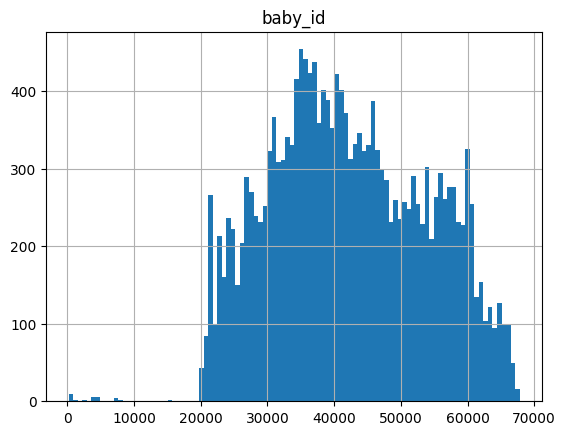

In [88]:
df_trainval.hist('baby_id', bins=100)
plt.show()

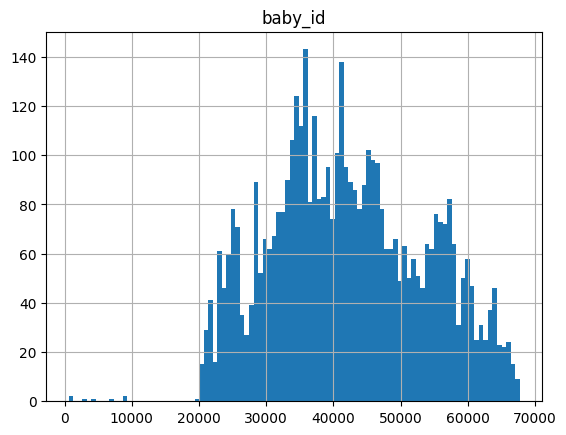

In [89]:
df_test.hist('baby_id',bins=100)
plt.show()

In [90]:
print(df_trainval['baby_id'].nunique(), df_test['baby_id'].nunique())

12854 3214


# Check Logistic regression performance

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def run_one_full_train_test(df_trainval, df_test, cols, model):
    x = df_trainval[cols]
    y = df_trainval['pcr_result']
    print(f"start to train: x.shape:{x.shape}, y.shape:{y.shape}")

    model.fit(x, y)
    print(f"Model: {model}")
    if getattr(model, 'predict_proba', False):
        print("Found predict_proba")
        pred_raw = model.predict_proba(df_trainval[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_trainval[cols])
    
    gt = df_trainval['pcr_result']

    print(pred_pos.shape, gt.shape)
    print("train set auc", roc_auc_score(gt, pred_pos))

    if getattr(model, 'predict_proba', False):
        pred_raw = model.predict_proba(df_test[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_test[cols])
    
    gt = df_test['pcr_result']
    test_result = roc_auc_score(gt, pred_pos)
    print("test set auc", test_result)
        
    return model, test_result

lr_model = LogisticRegression()

run_one_full_train_test(df_trainval, df_test, cols, lr_model)

start to train: x.shape:(18711, 64), y.shape:(18711,)
Model: LogisticRegression()
Found predict_proba
(18711,) (18711,)
train set auc 0.8523616789465512
test set auc 0.8416510257140007


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(LogisticRegression(), 0.8416510257140007)

## repeat 5 times

In [92]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lr_model
    )

start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8536460260599665
test set auc 0.8418617324532305
start to train: x.shape:(14968, 64), y.shape:(14968,)


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8521924556259323
test set auc 0.8415487608796515
start to train: x.shape:(14968, 64), y.shape:(14968,)


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8514619550541969
test set auc 0.8416251735299258
start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.854642575544378
test set auc 0.8412595824666369
start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8513765810630738
test set auc 0.8419745211855217


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8418617324532305, 1: 0.8415487608796515, 2: 0.8416251735299258, 3: 0.8412595824666369, 4: 0.8419745211855217}
mean: 0.8416539541029933 std: 0.0002503429729046297


### Use xgboost

In [94]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [95]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [96]:

run_one_full_train_test(df_trainval, df_test, cols, xg_reg)

start to train: x.shape:(18711, 64), y.shape:(18711,)
[16:44:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(18711,) (18711,)
train set 

(XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='reg:linear', ...),
 0.8412715934371142)

In [97]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        xg_reg
    )

start to train: x.shape:(14968, 64), y.shape:(14968,)
[16:44:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(14968,) (14968,)
train set 

In [98]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8397734250529169, 1: 0.8399769252098603, 2: 0.8401759641491977, 3: 0.8404991164501336, 4: 0.8403203245753149}
mean: 0.8401491510874848 std: 0.00025429387104055484


### LGBM

In [99]:
import lightgbm as lgb

In [100]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lgb_model
    )

start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.9243212259638268
test set auc 0.8551935665124077
start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.9232820803221583
test set auc 0.8584086173336836
start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.9244080103782857
test set auc 0.8574014116665187
start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.9248207082533365
test set auc 0.8546029699355114
start to train: x.shape:(14968, 64), y.shape:(14968,)
Model: LGBMClassifier(lear

In [101]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8551935665124077, 1: 0.8584086173336836, 2: 0.8574014116665187, 3: 0.8546029699355114, 4: 0.8569555186863247}
mean: 0.8565124168268892 std: 0.0014119193339345117


## TabNet

In [102]:
import pandas as pd
import numpy  as np
from tqdm.auto import tqdm
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import torch

start to train: x_train.shape:(14968, 64), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 64), y_val.shape:(3743,)
y_train mean:0.7230090860502405. y_val mean:0.7224151749933209


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65253 | train_auc: 0.54219 | valid_auc: 0.54935 |  0:00:01s
epoch 2  | loss: 0.48216 | train_auc: 0.70727 | valid_auc: 0.69618 |  0:00:05s
epoch 4  | loss: 0.45076 | train_auc: 0.79213 | valid_auc: 0.79007 |  0:00:08s
epoch 6  | loss: 0.44122 | train_auc: 0.81723 | valid_auc: 0.81404 |  0:00:11s
epoch 8  | loss: 0.43233 | train_auc: 0.8211  | valid_auc: 0.81927 |  0:00:14s
epoch 10 | loss: 0.42637 | train_auc: 0.81712 | valid_auc: 0.81494 |  0:00:18s
epoch 12 | loss: 0.42192 | train_auc: 0.81235 | valid_auc: 0.81414 |  0:00:21s
epoch 14 | loss: 0.42114 | train_auc: 0.82065 | valid_auc: 0.82008 |  0:00:24s
epoch 16 | loss: 0.41464 | train_auc: 0.83352 | valid_auc: 0.83179 |  0:00:27s
epoch 18 | loss: 0.41243 | train_auc: 0.83082 | valid_auc: 0.82725 |  0:00:31s
epoch 20 | loss: 0.41268 | train_auc: 0.84282 | valid_auc: 0.84015 |  0:00:34s
epoch 22 | loss: 0.41045 | train_auc: 0.84779 | valid_auc: 0.84476 |  0:00:37s
epoch 24 | loss: 0.41262 | train_auc: 0.84732 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=64, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


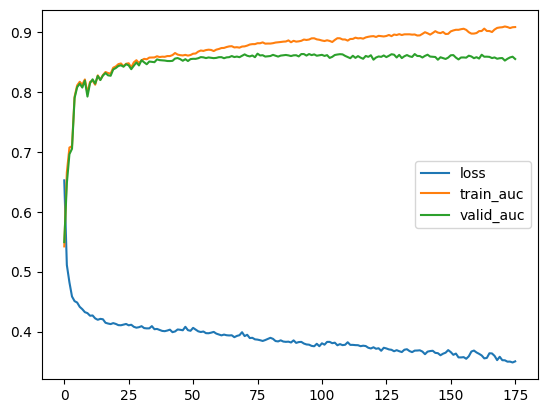

y_val.head:[1 0 1 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8641849169376563
start to test: x_test.shape:(4615, 64), y_test.shape:(4615,)


array([3.64608226e-02, 3.36140144e-04, 6.27944924e-02, 8.56283160e-04,
       3.82531279e-05, 1.23129538e-01, 0.00000000e+00, 2.70387678e-02,
       4.90932562e-02, 4.47289073e-02, 1.24381775e-01, 6.50185548e-06,
       2.12398543e-02, 7.84936285e-03, 7.13656981e-03, 0.00000000e+00,
       1.29300721e-01, 1.12809135e-02, 2.56104004e-04, 1.10045640e-02,
       7.90203781e-03, 1.92652106e-03, 2.97900922e-02, 0.00000000e+00,
       1.71875493e-05, 6.03826870e-06, 8.11195390e-07, 1.03158085e-02,
       4.22313574e-06, 8.00455747e-03, 2.07317630e-05, 0.00000000e+00,
       3.11496710e-02, 0.00000000e+00, 1.17132293e-02, 3.61666086e-03,
       1.87957643e-03, 3.93827231e-03, 4.04852022e-02, 0.00000000e+00,
       2.50359395e-02, 1.64971538e-03, 0.00000000e+00, 1.22836906e-05,
       8.72585501e-03, 3.94223737e-06, 1.09347583e-02, 9.02950441e-07,
       3.37442873e-06, 6.29977588e-03, 2.21982068e-06, 1.06155656e-01,
       1.06685272e-05, 0.00000000e+00, 2.54356356e-03, 6.09707236e-06,
      

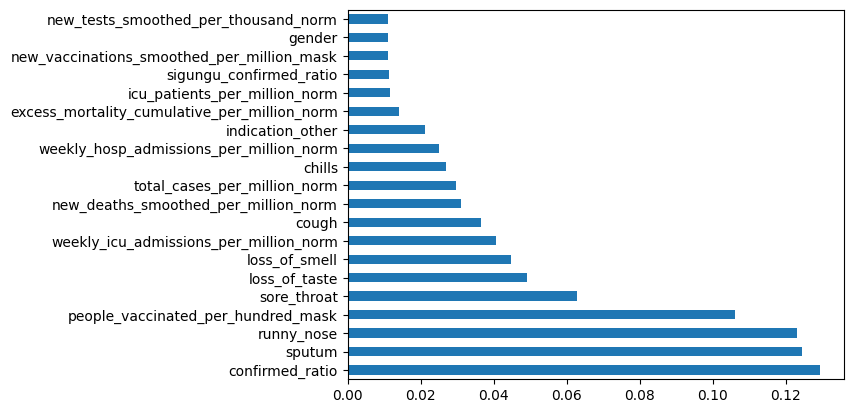

preds_test head:[[0.95552397 0.04447609]
 [0.9442661  0.05573386]
 [0.9364243  0.06357566]
 [0.9158515  0.08414853]
 [0.90434635 0.09565365]]
BEST AUC SCORE ON TEST SET : 0.8465492138648236
Best epoch:75
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0075.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0075.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0075.pth
start to train: x_train.shape:(14968, 64), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 64), y_val.shape:(3743,)
y_train mean:0.7221405665419561. y_val mean:0.7258883248730964


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67844 | train_auc: 0.60659 | valid_auc: 0.60802 |  0:00:01s
epoch 2  | loss: 0.49229 | train_auc: 0.73535 | valid_auc: 0.73746 |  0:00:06s
epoch 4  | loss: 0.45365 | train_auc: 0.80698 | valid_auc: 0.80934 |  0:00:09s
epoch 6  | loss: 0.44846 | train_auc: 0.8109  | valid_auc: 0.81421 |  0:00:12s
epoch 8  | loss: 0.43929 | train_auc: 0.81422 | valid_auc: 0.81711 |  0:00:15s
epoch 10 | loss: 0.43631 | train_auc: 0.82171 | valid_auc: 0.82561 |  0:00:19s
epoch 12 | loss: 0.42781 | train_auc: 0.82949 | valid_auc: 0.83279 |  0:00:22s
epoch 14 | loss: 0.42239 | train_auc: 0.8359  | valid_auc: 0.83808 |  0:00:25s
epoch 16 | loss: 0.42051 | train_auc: 0.83972 | valid_auc: 0.84058 |  0:00:29s
epoch 18 | loss: 0.41544 | train_auc: 0.84897 | valid_auc: 0.84766 |  0:00:32s
epoch 20 | loss: 0.41668 | train_auc: 0.84836 | valid_auc: 0.84828 |  0:00:35s
epoch 22 | loss: 0.41435 | train_auc: 0.8507  | valid_auc: 0.84855 |  0:00:38s
epoch 24 | loss: 0.40938 | train_auc: 0.85133 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=64, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


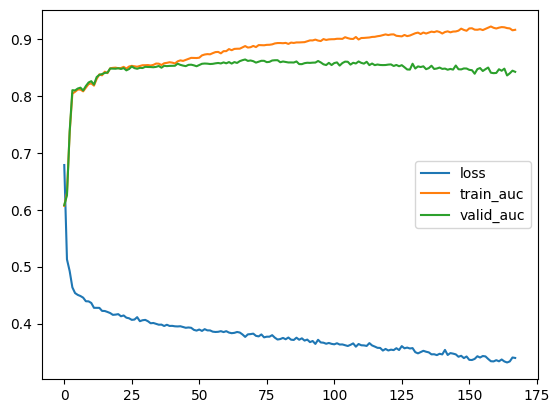

y_val.head:[1 1 1 1 0]
BEST AUC SCORE ON VALIDATION SET : 0.8636966296246074
start to test: x_test.shape:(4615, 64), y_test.shape:(4615,)


array([1.24755482e-05, 7.74629356e-02, 1.54980618e-02, 2.52199017e-01,
       3.41485409e-07, 1.42592301e-02, 5.02066094e-05, 7.85920749e-07,
       1.90940985e-03, 3.09510301e-02, 1.16282292e-01, 6.51023798e-03,
       1.24862778e-02, 6.15862881e-07, 2.52117545e-02, 8.94729922e-03,
       8.18714488e-02, 2.05798406e-04, 0.00000000e+00, 3.08618684e-03,
       5.37158562e-04, 6.06490971e-08, 1.07934013e-05, 1.83393690e-02,
       1.06436541e-03, 0.00000000e+00, 4.38842479e-02, 3.75271427e-02,
       2.90652098e-02, 0.00000000e+00, 6.09406894e-03, 0.00000000e+00,
       8.11479672e-03, 2.24351812e-02, 1.82508365e-02, 2.27931790e-02,
       2.32477380e-06, 5.90196538e-03, 1.97426573e-03, 1.68851660e-04,
       0.00000000e+00, 5.33363019e-04, 2.14445039e-02, 1.89742607e-03,
       3.88515528e-04, 5.86510956e-06, 3.59006469e-07, 5.09070772e-05,
       2.47267210e-05, 6.15409362e-03, 3.77312927e-03, 1.32989039e-03,
       2.19548495e-03, 6.46231114e-05, 2.46155097e-04, 7.79554987e-04,
      

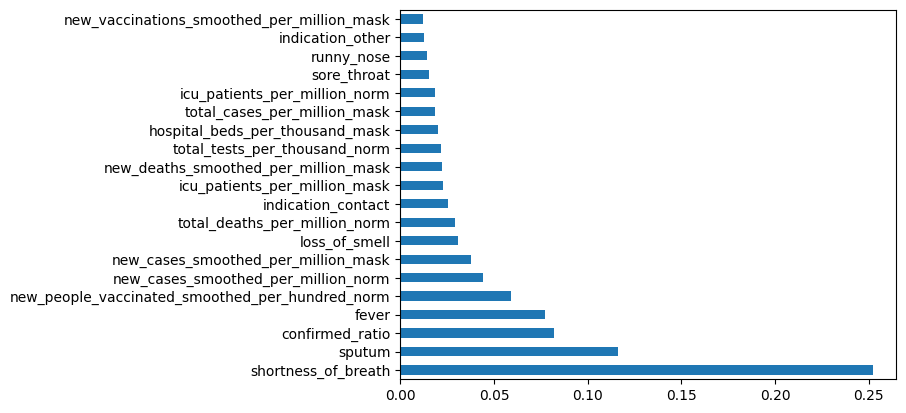

preds_test head:[[0.9563122  0.04368781]
 [0.9257649  0.07423507]
 [0.9074817  0.09251831]
 [0.8907975  0.10920244]
 [0.9098817  0.09011829]]
BEST AUC SCORE ON TEST SET : 0.8526912809963112
Best epoch:67
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0067.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0067.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0067.pth
start to train: x_train.shape:(14968, 64), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 64), y_val.shape:(3743,)
y_train mean:0.722407803313736. y_val mean:0.7248196633716271


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66885 | train_auc: 0.57406 | valid_auc: 0.5849  |  0:00:01s
epoch 2  | loss: 0.48514 | train_auc: 0.73191 | valid_auc: 0.73637 |  0:00:04s
epoch 4  | loss: 0.45284 | train_auc: 0.80741 | valid_auc: 0.80181 |  0:00:08s
epoch 6  | loss: 0.43846 | train_auc: 0.81638 | valid_auc: 0.81324 |  0:00:11s
epoch 8  | loss: 0.43466 | train_auc: 0.81896 | valid_auc: 0.81732 |  0:00:15s
epoch 10 | loss: 0.43127 | train_auc: 0.82156 | valid_auc: 0.81924 |  0:00:18s
epoch 12 | loss: 0.4278  | train_auc: 0.81339 | valid_auc: 0.81166 |  0:00:21s
epoch 14 | loss: 0.42052 | train_auc: 0.81752 | valid_auc: 0.81201 |  0:00:24s
epoch 16 | loss: 0.41944 | train_auc: 0.82372 | valid_auc: 0.81835 |  0:00:28s
epoch 18 | loss: 0.41446 | train_auc: 0.8318  | valid_auc: 0.82705 |  0:00:31s
epoch 20 | loss: 0.41569 | train_auc: 0.83962 | valid_auc: 0.83518 |  0:00:34s
epoch 22 | loss: 0.41452 | train_auc: 0.8477  | valid_auc: 0.84212 |  0:00:37s
epoch 24 | loss: 0.41364 | train_auc: 0.84451 | vali

epoch 208| loss: 0.35724 | train_auc: 0.90504 | valid_auc: 0.84907 |  0:05:40s
epoch 210| loss: 0.34482 | train_auc: 0.91606 | valid_auc: 0.85047 |  0:05:43s
epoch 212| loss: 0.34348 | train_auc: 0.91665 | valid_auc: 0.84248 |  0:05:47s
epoch 214| loss: 0.34052 | train_auc: 0.91886 | valid_auc: 0.84425 |  0:05:50s

Early stopping occurred at epoch 215 with best_epoch = 115 and best_valid_auc = 0.86333


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=64, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


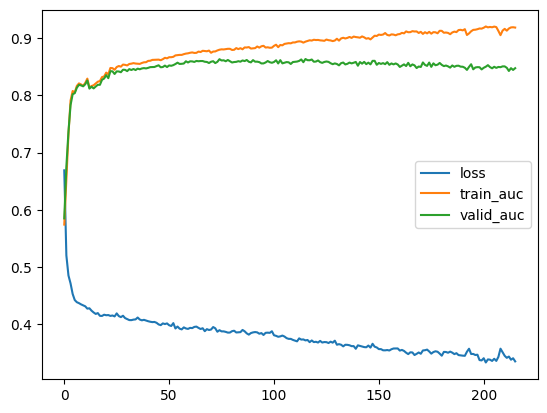

y_val.head:[1 1 1 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8633349317740187
start to test: x_test.shape:(4615, 64), y_test.shape:(4615,)


array([0.00000000e+00, 3.18018197e-02, 0.00000000e+00, 2.52824190e-06,
       2.62717384e-02, 7.32069997e-03, 3.45446888e-02, 1.57778366e-02,
       2.18272746e-06, 1.65099351e-02, 1.15298031e-01, 0.00000000e+00,
       7.31706617e-06, 2.20390232e-02, 7.62282341e-02, 1.92051397e-02,
       1.38483651e-01, 2.26798287e-02, 1.41305541e-06, 1.10846266e-05,
       9.03369943e-02, 6.85018394e-08, 3.67987034e-02, 4.82631012e-02,
       0.00000000e+00, 1.73666094e-06, 1.14919488e-04, 9.28231155e-03,
       1.02439534e-05, 3.29018856e-06, 2.13694940e-02, 1.69879479e-05,
       5.23287536e-05, 0.00000000e+00, 4.08826177e-02, 0.00000000e+00,
       2.98545658e-04, 0.00000000e+00, 1.18494892e-05, 0.00000000e+00,
       7.80276431e-06, 1.30167946e-05, 4.26752969e-05, 5.57251138e-03,
       4.26946151e-05, 1.16081364e-05, 2.01026992e-03, 5.24699767e-02,
       1.35464618e-05, 0.00000000e+00, 6.52600182e-06, 9.50110264e-03,
       2.26745360e-02, 2.70751062e-03, 4.91308102e-04, 1.27577429e-02,
      

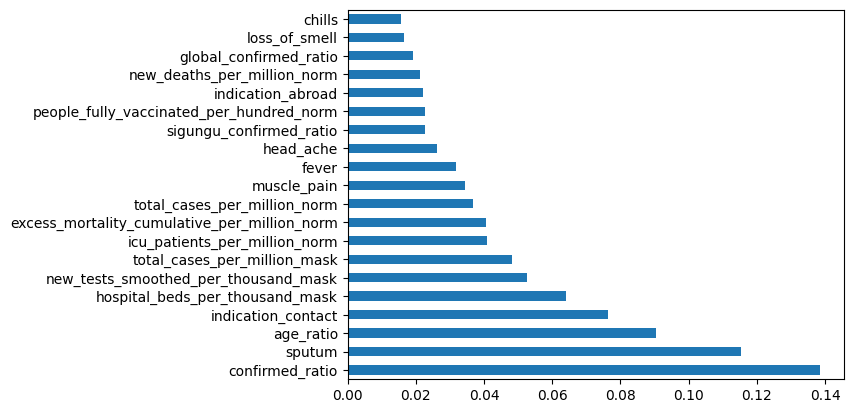

preds_test head:[[0.99365175 0.00634818]
 [0.9307813  0.06921866]
 [0.9880477  0.01195233]
 [0.9877439  0.01225606]
 [0.9808514  0.01914855]]
BEST AUC SCORE ON TEST SET : 0.8462506554558175
Best epoch:115
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0115.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0115.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0115.pth
start to train: x_train.shape:(14968, 64), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 64), y_val.shape:(3743,)
y_train mean:0.7213388562266168. y_val mean:0.7290943093775046


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68014 | train_auc: 0.67776 | valid_auc: 0.66987 |  0:00:01s
epoch 2  | loss: 0.4854  | train_auc: 0.75136 | valid_auc: 0.73982 |  0:00:05s
epoch 4  | loss: 0.4552  | train_auc: 0.76855 | valid_auc: 0.75955 |  0:00:08s
epoch 6  | loss: 0.44336 | train_auc: 0.80133 | valid_auc: 0.79275 |  0:00:11s
epoch 8  | loss: 0.44033 | train_auc: 0.81355 | valid_auc: 0.80649 |  0:00:14s
epoch 10 | loss: 0.43703 | train_auc: 0.81933 | valid_auc: 0.81241 |  0:00:18s
epoch 12 | loss: 0.42992 | train_auc: 0.82388 | valid_auc: 0.81597 |  0:00:21s
epoch 14 | loss: 0.42792 | train_auc: 0.82916 | valid_auc: 0.82356 |  0:00:24s
epoch 16 | loss: 0.4236  | train_auc: 0.83483 | valid_auc: 0.82868 |  0:00:27s
epoch 18 | loss: 0.41876 | train_auc: 0.84109 | valid_auc: 0.83327 |  0:00:30s
epoch 20 | loss: 0.41826 | train_auc: 0.84001 | valid_auc: 0.83187 |  0:00:34s
epoch 22 | loss: 0.41463 | train_auc: 0.84656 | valid_auc: 0.83807 |  0:00:37s
epoch 24 | loss: 0.41422 | train_auc: 0.8476  | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=64, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


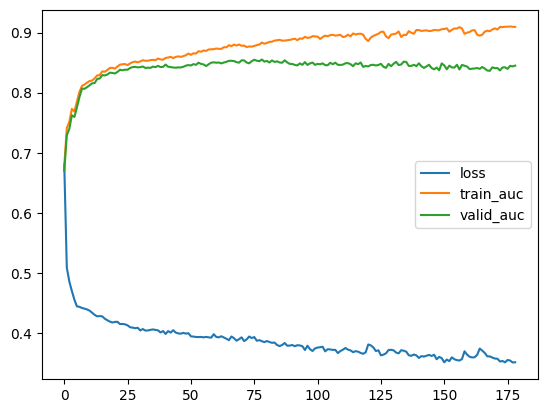

y_val.head:[0 1 1 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8551674504897719
start to test: x_test.shape:(4615, 64), y_test.shape:(4615,)


array([9.11043243e-02, 2.17481129e-03, 4.61360730e-02, 1.66612631e-04,
       1.36956077e-04, 3.11609565e-02, 4.51392853e-04, 9.26306575e-07,
       2.12539580e-02, 2.60281818e-02, 1.95485896e-01, 5.67820004e-05,
       8.81027720e-04, 5.76531090e-05, 7.23814600e-02, 0.00000000e+00,
       1.49022941e-01, 0.00000000e+00, 4.28412476e-02, 3.33704041e-04,
       1.28140662e-04, 0.00000000e+00, 3.37565747e-02, 0.00000000e+00,
       0.00000000e+00, 9.48624805e-04, 1.45259878e-05, 2.01768838e-06,
       9.11797406e-04, 5.66163671e-02, 2.93549365e-05, 0.00000000e+00,
       2.03660935e-02, 0.00000000e+00, 2.37766492e-03, 1.68835226e-02,
       1.21406124e-07, 2.10032167e-03, 0.00000000e+00, 1.44608272e-02,
       6.24761061e-02, 0.00000000e+00, 1.30390946e-02, 0.00000000e+00,
       1.88891868e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.36569840e-03, 5.91169181e-04, 2.67877856e-07, 2.75783766e-04,
       1.78599199e-02, 4.62888914e-06, 3.92915411e-02, 8.27188100e-06,
      

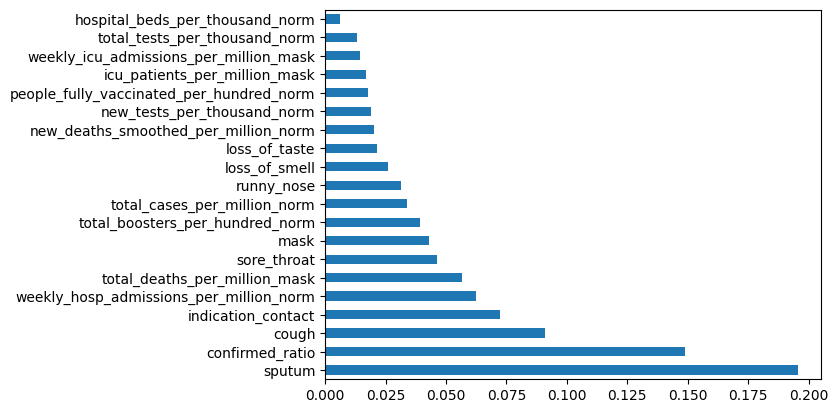

preds_test head:[[9.9566817e-01 4.3317671e-03]
 [9.9214840e-01 7.8515979e-03]
 [9.8188102e-01 1.8119058e-02]
 [9.9922419e-01 7.7584339e-04]
 [9.5612395e-01 4.3876022e-02]]
BEST AUC SCORE ON TEST SET : 0.8456920881335273
Best epoch:78
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0078.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0078.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0078.pth
start to train: x_train.shape:(14968, 64), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 64), y_val.shape:(3743,)
y_train mean:0.7214056654195617. y_val mean:0.7288271440021373


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67647 | train_auc: 0.69905 | valid_auc: 0.71112 |  0:00:01s
epoch 2  | loss: 0.47171 | train_auc: 0.7614  | valid_auc: 0.76992 |  0:00:05s
epoch 4  | loss: 0.45135 | train_auc: 0.79895 | valid_auc: 0.79858 |  0:00:08s
epoch 6  | loss: 0.43992 | train_auc: 0.81422 | valid_auc: 0.81205 |  0:00:11s
epoch 8  | loss: 0.4346  | train_auc: 0.80791 | valid_auc: 0.80697 |  0:00:15s
epoch 10 | loss: 0.43048 | train_auc: 0.80157 | valid_auc: 0.8048  |  0:00:18s
epoch 12 | loss: 0.42854 | train_auc: 0.80557 | valid_auc: 0.80633 |  0:00:22s
epoch 14 | loss: 0.42698 | train_auc: 0.82989 | valid_auc: 0.82917 |  0:00:25s
epoch 16 | loss: 0.42225 | train_auc: 0.82002 | valid_auc: 0.81873 |  0:00:29s
epoch 18 | loss: 0.42169 | train_auc: 0.82381 | valid_auc: 0.82118 |  0:00:32s
epoch 20 | loss: 0.42062 | train_auc: 0.83216 | valid_auc: 0.82665 |  0:00:35s
epoch 22 | loss: 0.4161  | train_auc: 0.83669 | valid_auc: 0.83344 |  0:00:39s
epoch 24 | loss: 0.41583 | train_auc: 0.83923 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=64, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


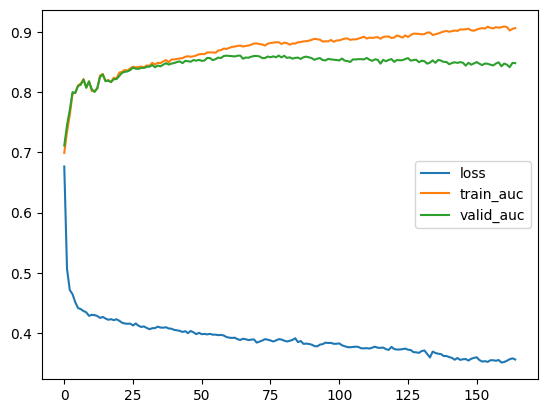

y_val.head:[1 0 1 0 0]
BEST AUC SCORE ON VALIDATION SET : 0.8604687025988472
start to test: x_test.shape:(4615, 64), y_test.shape:(4615,)


array([0.00000000e+00, 3.55841687e-02, 2.18030862e-02, 0.00000000e+00,
       6.20833597e-05, 1.81701022e-01, 2.66208055e-02, 1.18656742e-06,
       2.11934914e-02, 2.41115579e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.89326790e-04, 9.33456203e-08, 2.30768303e-02,
       1.15395336e-02, 9.23290989e-03, 1.58629115e-02, 1.35534495e-06,
       2.05874269e-02, 2.64941669e-03, 2.21595892e-06, 3.77281884e-04,
       4.53100123e-04, 1.07993867e-04, 7.02539694e-02, 6.45649800e-02,
       0.00000000e+00, 6.74782962e-03, 3.99032323e-03, 1.18975069e-02,
       3.22884576e-04, 3.37136390e-05, 7.43020174e-02, 1.70284808e-02,
       1.25050475e-02, 4.67164938e-06, 3.67460583e-03, 8.16403057e-04,
       2.80747071e-01, 1.49371634e-05, 4.85621085e-04, 7.03691486e-05,
       2.18013943e-02, 2.08386035e-06, 1.44444526e-02, 1.09352430e-05,
       0.00000000e+00, 1.71106483e-03, 0.00000000e+00, 8.62547147e-04,
       7.63692407e-03, 6.06876699e-03, 8.38585423e-03, 2.65980628e-08,
      

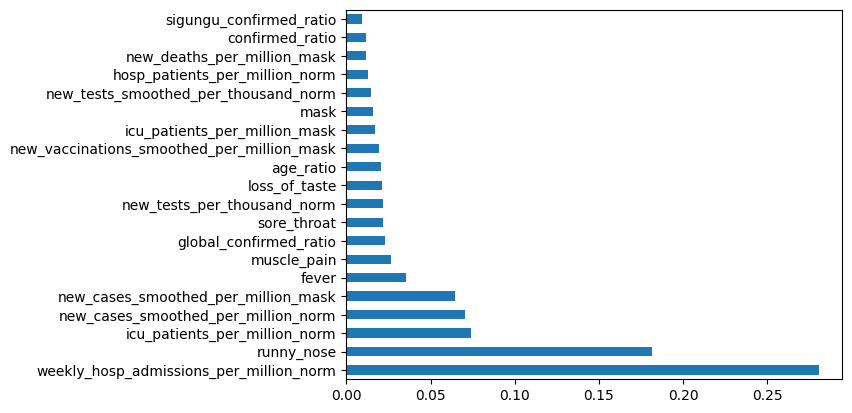

preds_test head:[[0.9069347  0.09306533]
 [0.9069347  0.09306533]
 [0.9069347  0.09306533]
 [0.9606329  0.03936701]
 [0.9069347  0.09306533]]
BEST AUC SCORE ON TEST SET : 0.8485493264247758
Best epoch:64
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0064.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0064.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0064.pth


<Figure size 640x480 with 0 Axes>

In [103]:
def run_one_full_train_test_with_tabnet(df_trainval, df_test, cols, model):
    df_train, df_val = train_test_split(df_trainval, test_size=0.2)
    x_train = df_train[cols].to_numpy()
    y_train = df_train['pcr_result'].to_numpy()
    x_val = df_val[cols].to_numpy()
    y_val = df_val['pcr_result'].to_numpy()
    x_test = df_test[cols].to_numpy()
    y_test = df_test['pcr_result'].to_numpy()

    print(f"start to train: x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}")
    print(f"start to train: x_val.shape:{x_val.shape}, y_val.shape:{y_val.shape}")
    print(f"y_train mean:{np.mean(y_train)}. y_val mean:{np.mean(y_val)}")

    model.fit(
        X_train=x_train, y_train=y_train,
        eval_set=[(x_train, y_train), (x_val, y_val)],
        eval_name=['train', 'valid'],
#         patience=2, 
#         max_epochs=100,
        patience=100, 
        max_epochs=1000,
        eval_metric=['auc'],
    )
    
    print(f"Model: {model}")
    # plot losses
    plt.plot(model.history['loss'], label='loss')

    # plot accuracy
    plt.plot(model.history['train_auc'], label='train_auc')
    plt.plot(model.history['valid_auc'], label='valid_auc')
    plt.legend(['loss', 'train_auc', 'valid_auc'])
    plt.show()
    plt.clf()

    # determine best accuracy for validation set
    preds_valid = model.predict_proba(x_val)
    print(f"y_val.head:{y_val[:5]}")
    pred_pos = np.array([x[1] for x in preds_valid])
    valid_auc = roc_auc_score(y_val, pred_pos)
    print(f"BEST AUC SCORE ON VALIDATION SET : {valid_auc}")
    
    print(f"start to test: x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}")
    # find and plot feature importance
    y_pred = model.predict(x_test)
    feature_importances_ = model.feature_importances_
    display(feature_importances_)
    feat_importances = pd.Series(model.feature_importances_, index=cols)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    plt.clf()

    # determine best accuracy for test set
    preds = model.predict_proba(x_test)
    pred_pos = np.array([x[1] for x in preds])
    test_auc = roc_auc_score(y_test, pred_pos)
    print(f"preds_test head:{preds[:5]}")
    print(f"BEST AUC SCORE ON TEST SET : {test_auc}")
    
    config_name = 'TabNet_DEFAULT'
    best_epoch, element = max(enumerate(model.history['valid_auc']), key=lambda x: x[1])
    print(f"Best epoch:{best_epoch}")
    best_model = save_model(config_name, model, best_epoch)
    
    return model, test_auc

def save_model(config_name, model, epoch):
    save_path = f"./train_data/{model.__class__.__name__}_{config_name}_{epoch:04d}.pth"
    print("save_path", save_path)
    model.save_model(save_path)
    print("Success to save to : ", save_path)
    return model


test_result = dict()
models = dict()
for i in range(5):
    tab_model = TabNetClassifier(verbose = 2,seed = 1212)
    models[i], test_result[i] = run_one_full_train_test_with_tabnet(
        df_trainval, 
        df_test, cols,
        tab_model
    )
    

In [104]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8465492138648236, 1: 0.8526912809963112, 2: 0.8462506554558175, 3: 0.8456920881335273, 4: 0.8485493264247758}
mean: 0.847946512975051 std: 0.002560742725296901



## 날짜 check (monthly)

In [6]:
df_tmp = df_all.copy()
df_tmp['month'] = df_tmp['self_check_date'].apply(lambda x : x[:7])
df_tmp['month'].sample(10)

6231     2022-03
10423    2022-04
8292     2022-04
1233     2022-03
105      2022-01
2151     2022-03
20557    2022-03
8570     2022-04
14851    2022-03
5011     2022-03
Name: month, dtype: object

In [7]:
df_tmp.groupby('month').size()

month
2021-11        3
2021-12      104
2022-01      141
2022-02      400
2022-03    12476
2022-04     5408
2022-05      817
2022-06      484
2022-07     1003
2022-08     1405
2022-09      712
2022-10      373
dtype: int64